In [30]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

TEST_SPLIT = 0.2
SEED = 42

IMAGES_PATH = "/home/peter/Pictures/thermometer-photos/flat/"


def load_dataset():
    x_train = tf.keras.utils.image_dataset_from_directory(
        IMAGES_PATH,
        labels=None,
        label_mode=None,
        batch_size=None,
        seed=SEED,
        validation_split=TEST_SPLIT,
        subset="training",
    )
    x_test = tf.keras.utils.image_dataset_from_directory(
        IMAGES_PATH,
        labels=None,
        label_mode=None,
        batch_size=None,
        seed=SEED,
        validation_split=TEST_SPLIT,
        subset="validation",
    )
    y_train = tf.keras.utils.text_dataset_from_directory(
        IMAGES_PATH,
        labels=None,
        label_mode=None,
        batch_size=None,
        seed=SEED,
        validation_split=TEST_SPLIT,
        subset="training",
    )
    y_test = tf.keras.utils.text_dataset_from_directory(
        IMAGES_PATH,
        labels=None,
        label_mode=None,
        batch_size=None,
        seed=SEED,
        validation_split=TEST_SPLIT,
        subset="validation",
    )
    return x_train, x_test, y_train, y_test


Found 12 files belonging to 1 classes.
Using 10 files for training.
Found 12 files belonging to 1 classes.
Using 2 files for validation.
Found 12 files belonging to 1 classes.
Using 10 files for training.
Found 12 files belonging to 1 classes.
Using 2 files for validation.
Finished loading data


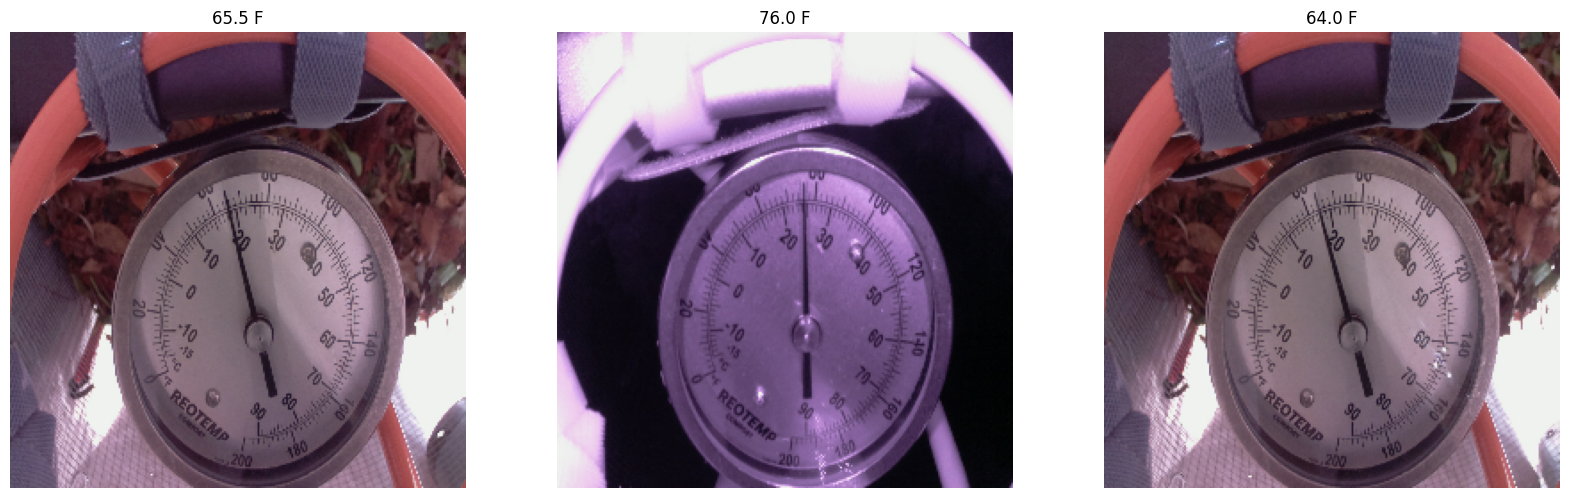

In [51]:
x_train, x_test, y_train, y_test = load_dataset()

print("Finished loading data")

y_train = y_train.map(lambda x: tf.strings.to_number(x))
y_test = y_test.map(lambda x: tf.strings.to_number(x))

# Print out 3 images with labels
plt.figure(figsize=(20, 20))
i = 0
for image, label in tf.data.Dataset.zip((x_train, y_train)).take(3):
    i += 1
    plt.subplot(1, 3, i)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"{label.numpy()} F")
    plt.axis("off")


def normalize_image(img: np.ndarray):
    # standardize
    img = img / 255.
    # convert to 1D array
    img = img.reshape(-1).T
    return img


x_train = x_train.map(lambda img: tf.numpy_function(normalize_image, inp=[img], Tout=[tf.float32]))
x_test = x_test.map(lambda img: tf.numpy_function(normalize_image, inp=[img], Tout=[tf.float32]))
